# Лабораторная работа №3. Рябиков Илья

## 0. Импортируем библиотеки и подгружаем данные

In [1]:
!pip install finam-export
!pip install yfinance
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for finam-export: filename=finam_export-5.1.1-py3-none-any.whl size=12060 sha256=5592b50a8b6ce920bde3b4ff339a4507905a35e10f5e044ead7d7c6683e54130
  Stored in directory: /root/.cache/pip/wheels/76/3d/ea/47fb1aa5f0bca292168a0440644f5d705c6688ef3e1af273fd
Successfully built finam-export
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 3.8 MB/s 
     |████████████████████████████████| 52 kB 878 kB/s 
     |████████████████████████████████| 1.6 MB 40.0 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88682 sha256=183f994058911c8795b1c4deab05db7f9802083a8095dbcdf750e9ba5385a7e1
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=07a0a2ecc9bbd82c099d253ca22eab560de1a5e8ccf57224f179ac0aa4d7bc8d
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [13]:
!pip install eventstudy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 60 kB/s 


In [3]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd

import requests
from finam import Exporter, Market, LookupComparator

import pyfolio as pf


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [4]:
from finam import Exporter, Market, LookupComparator

def get_finam_stock(ticker):
  exporter = Exporter()
  buff = exporter.lookup(code =ticker, market=Market.SHARES)
  id =  buff.index.values.astype(int)
  id = min(id)
  buff = exporter.download(id, market = Market.SHARES)
  buff['date'] = pd.to_datetime(buff['<DATE>'], format='%Y%m%d', errors='coerce')
  index = np.array(buff["date"], dtype=np.datetime64)
  buff.set_index(index, inplace=True)
  buff['log_rtn'] = np.log(buff['<CLOSE>']) - np.log(buff['<CLOSE>'].shift(1))
  buff = buff.loc[~buff.index.duplicated(keep='first')] # remove duplicate indexes 
  return(buff)

In [5]:
my_stock = 'LKOH'

my_stock_df = get_finam_stock(my_stock)


In [6]:
def get_finam_index(id):
  exporter = Exporter()
  buff = exporter.download(id, market = Market.INDEXES)
  buff['date'] = pd.to_datetime(buff['<DATE>'], format='%Y%m%d', errors='coerce')
  index = np.array(buff["date"], dtype=np.datetime64)
  buff.set_index(index, inplace=True)
  buff['log_rtn'] = np.log(buff['<CLOSE>']) - np.log(buff['<CLOSE>'].shift(1))
  return(buff)

In [7]:
rf = get_finam_index(82308)

In [8]:
moex = get_finam_index(175802)

In [9]:
rf = rf[~rf.index.duplicated(keep='first')]

In [10]:
moex = moex[~moex.index.duplicated(keep='first')]

## 1. Построение портфелей

### Портфель 60% индекс Мосбиржи + 40% индекс гособлигаций

In [11]:
weights_1 = [0.6,0.4]

In [12]:
rtns_1 = pd.concat([moex['log_rtn'], my_stock_df['log_rtn']], axis = 'columns')
rtns_1.columns = ['MOEX', my_stock] 
rtns_1 = rtns_1.dropna()

In [ ]:
portfolio_1 = pd.Series(np.dot(rtns_1, weights_1), index=rtns_1.index)

In [ ]:
avg_returns_1 = rtns_1.mean() * 252

In [ ]:
cov_mat_1 = rtns_1.cov() * 252

Посчитаем доходность и волатильность портфеля из Индекса Мосбиржи и гособлигаций, а также его коэффициент Шарпа, как соотношение доходности к риску

In [ ]:
portf_rtns_1 = np.dot(weights_1, avg_returns_1)
portf_vol_1 = np.sqrt(np.dot(weights_1, np.dot(cov_mat_1, weights_1)))
portf_sharpe_ratio_1 = portf_rtns_1 / portf_vol_1 # assuming zero interest free rat

In [ ]:
print(f'Sharpe ratio for 1st portfolio: {round(portf_sharpe_ratio_1, 2)}')

Sharpe ratio for 1st portfolio: 0.22


### Портфель 60% акций + 40% индекс гособлигаций

In [ ]:
weights_2 = [0.6,0.4]

In [ ]:
rtns_2 = pd.concat([my_stock_df['log_rtn'], rf['log_rtn']], 
                    axis = 'columns')
rtns_2.columns = [my_stock, 'RGBI'] 
rtns_2 = rtns_2.dropna()

In [ ]:
portfolio_2 = pd.Series(np.dot(rtns_2, weights_2), index=rtns_2.index)

In [ ]:
avg_returns_2 = rtns_2.mean() * 252

In [ ]:
cov_mat_2 = rtns_2.cov() * 252

Также посчитаем метрики портфеля из акций и индекса гособлигаций

In [ ]:
portf_rtns_2 = np.dot(weights_2, avg_returns_2)
portf_vol_2 = np.sqrt(np.dot(weights_2, np.dot(cov_mat_2, weights_2)))
portf_sharpe_ratio_2 = portf_rtns_2 / portf_vol_2 # assuming zero interest free rat

In [ ]:
print(f'Sharpe ratio for 2nd portfolio: {round(portf_sharpe_ratio_2, 2)}')

Sharpe ratio for 2nd portfolio: 0.25


### Портфель 100% индекс гособлигаций

In [ ]:
weights_3 = [1]

In [ ]:
rtns_3 = pd.concat([rf['log_rtn']], 
                    axis = 'columns')
rtns_3.columns = ['RGBI'] 
rtns_3 = rtns_3.dropna()

In [ ]:
portfolio_3 = pd.Series(np.dot(rtns_3, weights_3), index=rtns_3.index)

In [ ]:
avg_returns_3 = rtns_3.mean() * 252

In [ ]:
cov_mat_3 = rtns_3.cov() * 252

Посчитаем метрики для последнего портфеля только из индекса ОФЗ

In [ ]:
portf_rtns_3 = np.dot(weights_3, avg_returns_3)
portf_vol_3 = np.sqrt(np.dot(weights_3, np.dot(cov_mat_3, weights_3)))
portf_sharpe_ratio_3 = portf_rtns_3 / portf_vol_3 # assuming zero interest free rat

In [ ]:
print(f'Sharpe ratio for 3rd portfolio: {round(portf_sharpe_ratio_3, 2)}')

Sharpe ratio for 3rd portfolio: -0.01


Сравним также полученные коэффициенты Шарпа для трех портфелей с посчитанными встроенными в библиотеку PyPortolioOpt методами

## 2. Основные метрики *портфелей*

### Портфель 1

Start date,2013-05-21
End date,2022-10-21
Total months,112
,Backtest
Annual return,2.1%
Cumulative returns,21.6%
Annual volatility,25.8%
Sharpe ratio,0.22
Calmar ratio,0.04
Stability,0.67
Max drawdown,-60.2%


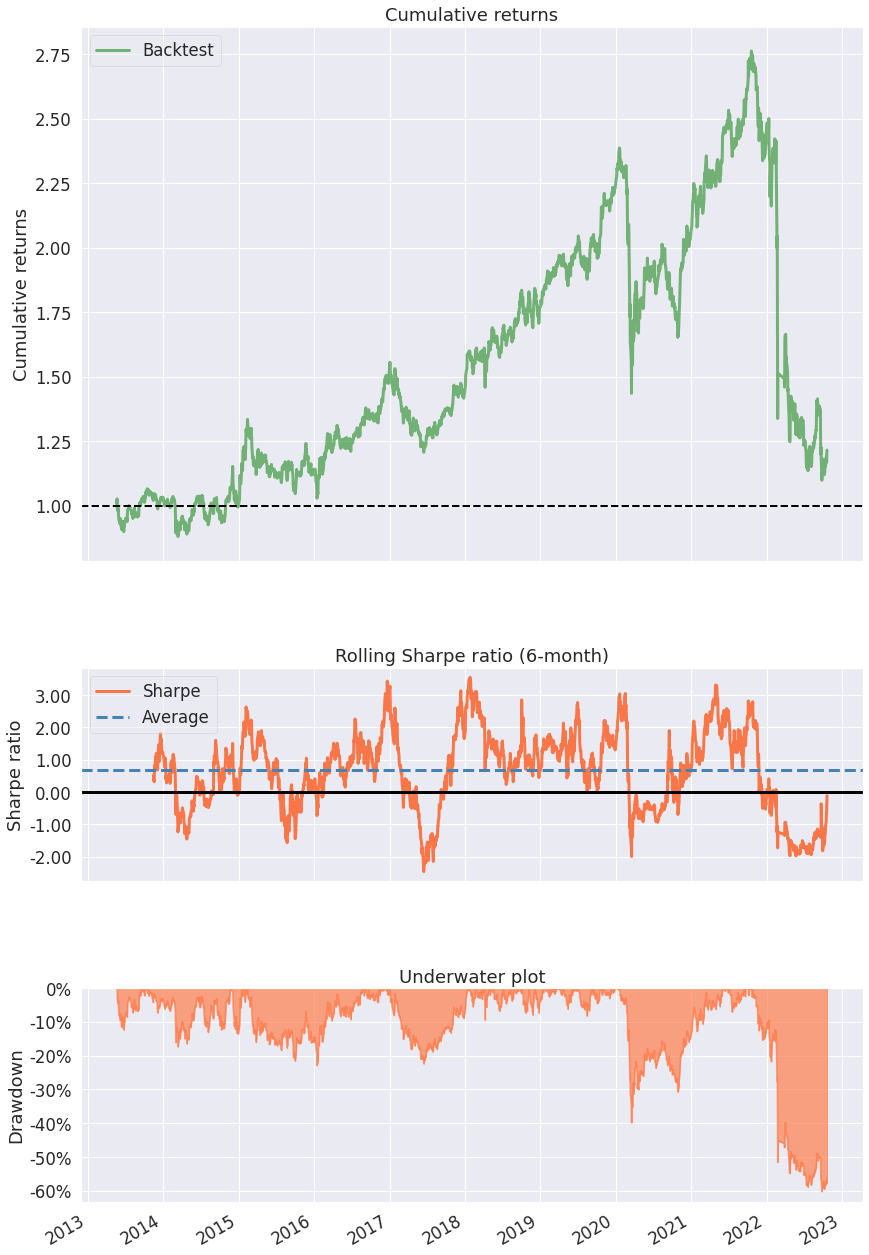

In [ ]:
pf.create_simple_tear_sheet(portfolio_1)

### Портфель 2

Start date,2012-03-06
End date,2022-10-21
Total months,126
,Backtest
Annual return,2.9%
Cumulative returns,35.9%
Annual volatility,19.3%
Sharpe ratio,0.25
Calmar ratio,0.07
Stability,0.76
Max drawdown,-41.9%


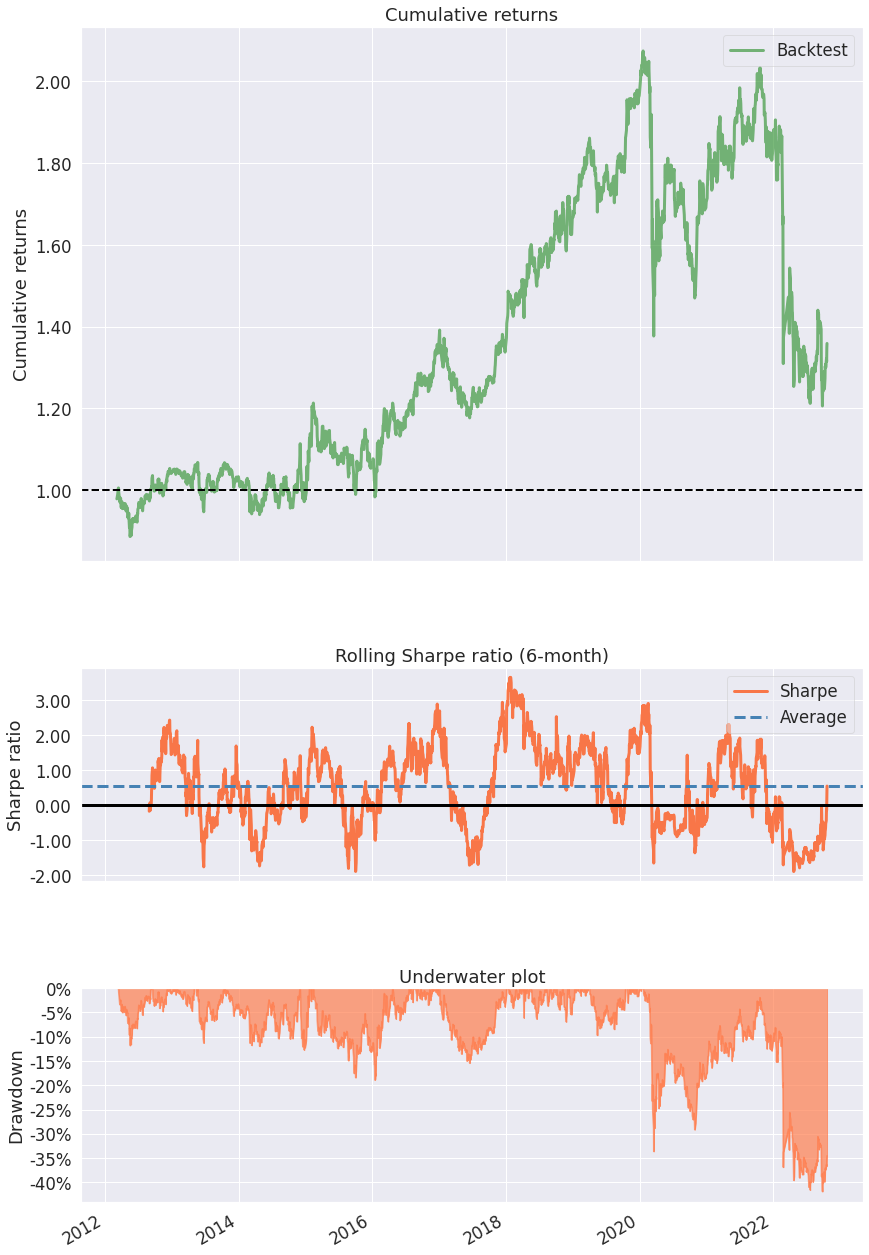

In [ ]:
pf.create_simple_tear_sheet(portfolio_2)

### Портфель 3

Start date,2012-03-06
End date,2022-10-21
Total months,126
,Backtest
Annual return,-0.5%
Cumulative returns,-5.2%
Annual volatility,8.9%
Sharpe ratio,-0.01
Calmar ratio,-0.01
Stability,0.13
Max drawdown,-36.1%


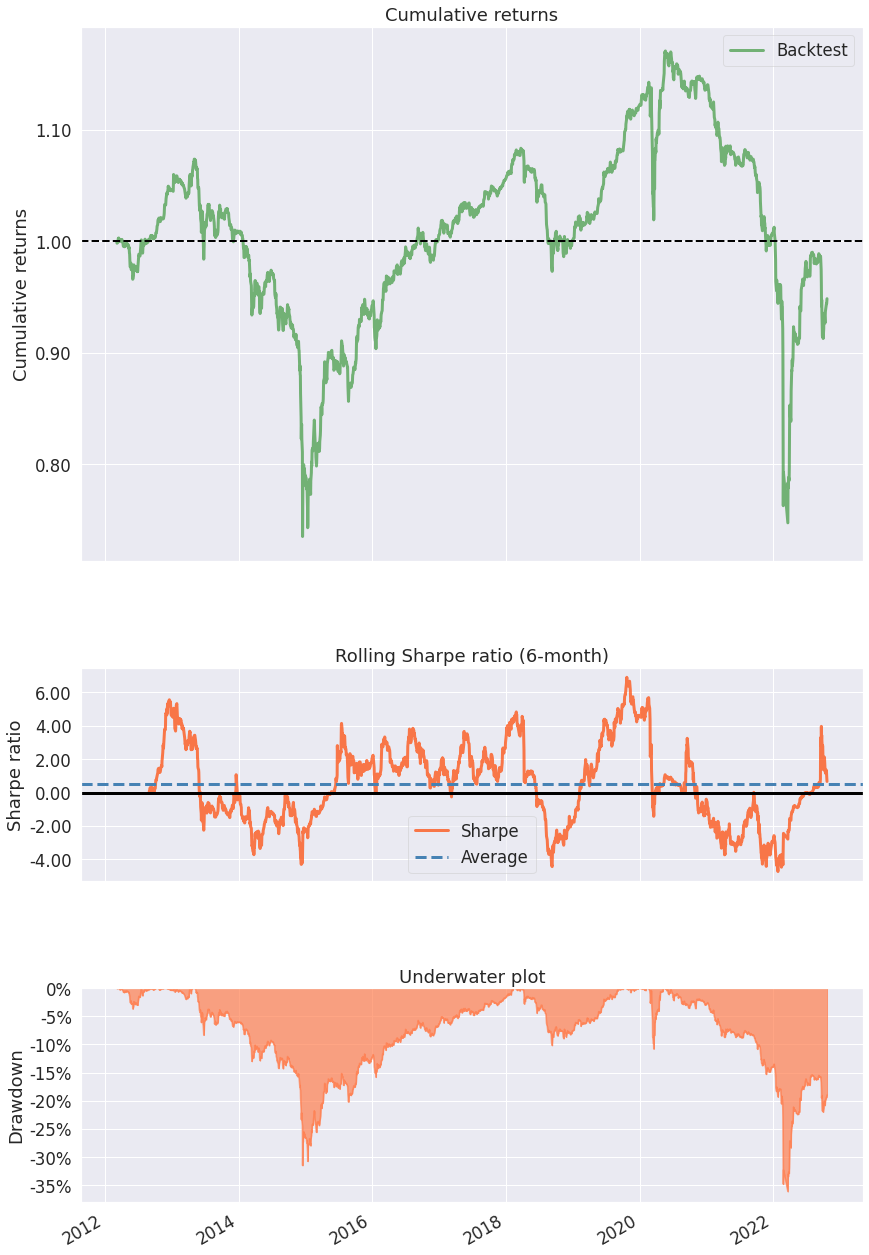

In [ ]:
pf.create_simple_tear_sheet(portfolio_3)

Самым качественным по совокупности всех метрик (годовая доходность, накопительная доходность, волатильность => Sharp ratio, стабильность, максимальная просадка) является, конечно, второй портфель, в составе которого присутствуют акции. Несмотря на то, что обычно доходность нефтегазовых компаний ведет себя близко к  рыночной, в данном случае портфель с акциями показал себя немного лучше. Третий портфель - из индекса гособлигаций, имеет околонулевую годовую доходность и отрицательную накопленную. Конечно, волатильность этого облигационного портфеля также ниже, из-за чего в результате коэффициент Шарпа почти равен нулю.

Интересно, что коэффициент Шарпа, посчитанный вручную и встроенным в библиотеку методами совпал. Значит все посчитано правильно!

## 3. CAPM

Построим модель САРМ для определения связи доходности акций Лукойла и рыночной доходности. Предположу, что индекс Мосбиржи и Лукойл будут идти параллельно, поскольку добыча нефти является одной из ключевых отраслей в России, и нефтегазовым компаниям свойственно идти параллельно с рынком и иметь рыночный коэффициент бета.

In [ ]:
capm = pd.merge(rf["log_rtn"],moex["log_rtn"], how='inner', left_index=True, right_index=True)
capm = pd.merge(capm,my_stock_df["log_rtn"], how='inner', left_index=True, right_index=True)
capm.columns = ["rf", "MOEX", 'LKOH']
capm = capm.dropna()

In [ ]:
x1 = np.linspace(-0.4,0.4,100)
y1 = x1

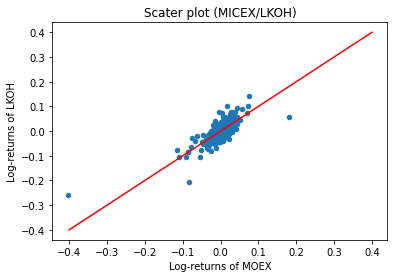

In [ ]:
capm.plot(x = "MOEX", y = "LKOH", kind='scatter')
plt.plot(x1, y1, 'r')
plt.xlabel('Log-returns of MOEX')
plt.ylabel('Log-returns of LKOH')
plt.title('Scater plot (MICEX/LKOH)')
plt.show()

Судя по графику, акции Лукойла часто ведут себя также, как рынок, колебаясь возле графика r(LKOH) = r(MOEX). Ожидаем коэффициент бета возле единицы

In [ ]:
capm['ex_lkoh_rtns'] = capm['LKOH'] - capm['rf']
capm['ex_moex_rtns'] = capm['MOEX'] - capm['rf']

In [ ]:
import statsmodels.api as sm

Построим линейную регрессию зависимости доходности Лукойла от рыночной доходности

In [ ]:
X = capm['ex_moex_rtns']
y = capm['ex_lkoh_rtns']
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y, X)

In [ ]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ex_lkoh_rtns   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     2696.
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:28:04   Log-Likelihood:                 6935.2
No. Observations:                2356   AIC:                        -1.387e+04
Df Residuals:                    2354   BIC:                        -1.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.541   

И на графике, и после построения модели и оценки коэффициента бета мы можем заметить, что рынок и акции Лукойла идут пракически параллельно, что согласуется с нашими предположениями о том, что акции нефтяного гиганта будут изменяться аналогично российскому рынку ценных бумаг. Коэффициент бета статистически значим (по t-тесту)


## 4. Event study

Исследуем поглощение компанией Лукойл футбольного клуба Спартак, которое было [анонсированно](https://www.lukoil.com/PressCenter/Pressreleases/Pressrelease?rid=593633) 22.08.2022. Для этого посмотрим на доходности Лукойла и рынка за 5 дней до, и через 20 дней после, а также в день анонса. Поскольку у Лукойла бета примерно равна 1, можно проверить статистическую значимость влияния доходности Лукойла на рынок без преобразований. Воспользуемся библиотекой [eventstudy](https://lemairejean-baptiste.github.io/eventstudy/get_started.html#)

In [14]:
import eventstudy as es


In [37]:
lkoh = my_stock_df[['log_rtn']].reset_index().dropna()

In [38]:
lkoh.rename(columns={'index':'date', 'log_rtn':'LKOH'}, inplace=True)

In [39]:
market = moex[['log_rtn']].reset_index().dropna()

In [40]:
market.rename(columns={'index':'date', 'log_rtn':'MOEX'}, inplace=True)

In [41]:
all = lkoh.merge(market, how='inner', on='date')

In [43]:
all.to_csv('my_stock.csv')

In [44]:
es.Single.import_returns('my_stock.csv')
# es.Single.import_returns('market.csv')

In [45]:
event = es.Single.market_model(
    security_ticker = 'LKOH',
     market_ticker = 'MOEX',
     event_date = np.datetime64('2022-08-22'),
     event_window = (-5,+20)
     )

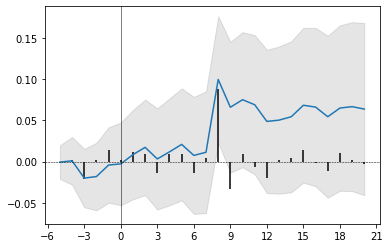

In [46]:
event.plot(AR=True)
plt.show() 

In [47]:
event.results(decimals=[3,5,3,5,2,2])


,AR,Std. E. AR,CAR,Std. E. CAR,T-stat,P-value
-5,-0.001,0.01599,-0.001,0.01599,-0.04,0.97
-4,0.002,0.01599,0.001,0.02261,0.04,0.97
-3,-0.021,0.01599,-0.02,0.02769,-0.73,0.47
-2,0.002,0.01599,-0.018,0.03197,-0.57,0.57
-1,0.014,0.01599,-0.004,0.03574,-0.12,0.91
0,0.001,0.01599,-0.003,0.03916,-0.07,0.94
1,0.011,0.01599,0.008,0.04229,0.20,0.84
2,0.009,0.01599,0.017,0.04521,0.38,0.70
3,-0.014,0.01599,0.003,0.04796,0.07,0.95
4,0.009,0.01599,0.012,0.05055,0.23,0.82


Поглощение не оказало статистическую значимость на доходность Лукойла - p-value по тесту Стьюдента очень велико. В целом в жизни компании Лукойл и так очень много места занимал Спартак - компания титульный спонсор московской команды, поэтому инвесторы восприняли поглощение как само собой разумеющееся.

## 5. Вывод

В результате анализа акций компании Лукойл, а именно метрик доходности и волатильности в сравнении с рыночной и безрисковой доходностями, а также влияние на акции Лукойла рыночных колебаний, мы выяснили, что портфель, состоящий из 60% акций Лукойла + 40% индекса гособлигаций все таки лучше портфеля с 60% индекса Мосбиржи + 40% индекса гособлигаций, но цифры очень близки, поскольку, как было посчитано, коэффициент бета для Лукойла почти равен 1, что говорит о том, что рыночная доходность почти на 100% объясняет доходность акций лукойла. Это свойственно нефтегазовым компаниям в России, поэтому теоретические выкладки лишь подтвердились. 
Говоря о конкретных событиях в жизни корпорации Лукойл, то рассмотренное в качестве примера поглощение футбольного клуба Спартак согласно модели САРМ никак не сказалось на Лукойле - статистической значимости влияния события на доходность относительно рыночной нет.